*** Module 3: Waves ***

# Sods Shock tube, Richtmyer method #

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

import sympy
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

In [2]:
def vector_u(rho,u,p):
    # there is a little problem because the name of the vector is the same as the name of the velocity variable 
    #we change it into vector_u but it is a bit cumbersome
    #v=numpy.zeros((3,len(rho)))
    v=numpy.array([rho,rho*u,rho*(p/(0.4*rho)+0.5*(u)**2)])
    return v

$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$

In [3]:
def computef(uv):
    # We define f as a function of u
    f=numpy.zeros_like((uv))
    f[0]=uv[1]
    f[1]=uv[1]**2/uv[0]+0.4*(uv[2]-0.5*uv[1]**2/uv[0])
    f[2]=(uv[1]/uv[0])*(uv[2]+0.4*(uv[2]-0.5*uv[1]**2/uv[0]))
    return f

In [4]:
dx= 0.25 #meter
dt=0.0002 #second
nx=81 #so that we cover 20 km, from -10 to +10

In [5]:
x=numpy.linspace(-10,10,nx)

In [6]:
IC=numpy.zeros((3,nx))
IC[0,:40]=1.0 #kg/m³
IC[0,40:]=0.125 #kg/m³
IC[1,0:]=0.0 #m/s
IC[2,:40]=100000.0 #N/m²
IC[2,40:]=10000.0 #N/m²
#print(IC)

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}

In [110]:
def Shock(v0,nt):
    uu=v0.copy()
    predictor=numpy.zeros((3,80))
    for t in range(nt):
        
        vv=uu.copy()
        f=computef(uu)
        predictor[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(predictor)
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])
        uu=vv.copy()
        
    return uu

In [122]:
v0=vector_u(IC[0],IC[1],IC[2])
shock=Shock(v0,50)

In [123]:
def ans(j,vector):
    v=numpy.ones(3)
    v[0]=vector[0,j]
    v[1]=vector[1,j]/vector[0,j]
    v[2]=0.4*(vector[2,j]-0.5*vector[1,j]**2/vector[0,j])
    return v

In [124]:
def plot(vector):
    #we create a function that will give us directly the density, the velocity and the pressure as a vector
    v=numpy.ones((3,81))
    for j in range(81):
            v[:,j]=ans(j,vector)
    return v

In [125]:
def graph(ordonnée,ymin,ymax,title):
    pyplot.plot(x,ordonnée, color='#003366', lw=1)
    pyplot.ylim(ymin,ymax);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel(title, fontsize=14) #y label,
    pyplot.title(title, y=1.08, fontsize=15) ;

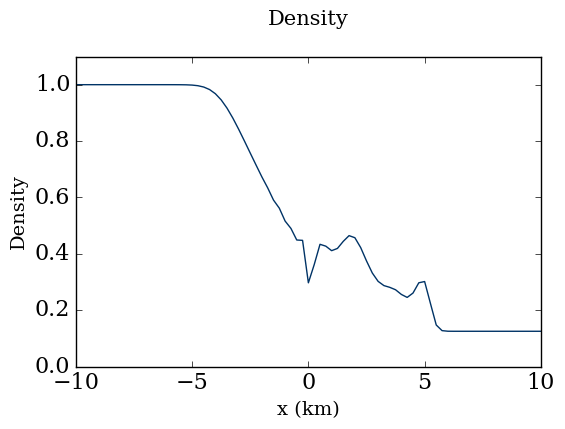

In [126]:
graph(plot(shock)[0],0.0,1.1,'Density')

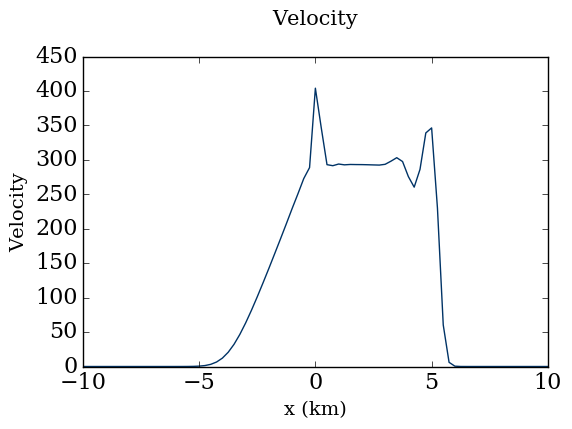

In [127]:
graph(plot(shock)[1],0.0,450.0,'Velocity')

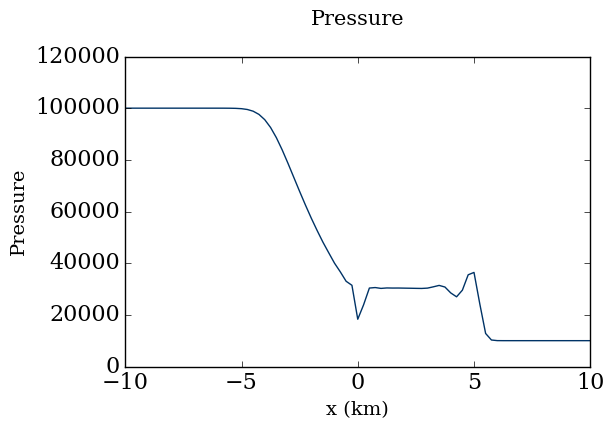

In [128]:
graph(plot(shock)[2],0.0,120000.0,'Pressure')

In [129]:
ans(50,shock)

array([  3.74691403e-01,   2.92611472e+02,   3.02508902e+04])